## referensi
1. Effectiveness of focal loss for minority classification in network intrusion detection systems (Doi :10.3390/sym13010004)
2. Deep learning approach for intelligent intrusion detection system https://ieeexplore.ieee.org/document/8681044
3. Applying convolutional neural network for network intrusion detection. In Proceedings of the International Conference on Advances in Computing ()
4. SMOTE: Synthetic minority over-sampling technique ()

In [53]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn
from IPython.core.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

from bayes_opt import BayesianOptimization

from sklearn.model_selection import train_test_split, cross_val_predict

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

import gc

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

In [2]:
# Load the dataset
df1 = pd.read_csv("../../Data/unsw-nb2015/UNSW-NB15 - CSV Files/a part of training and testing set/UNSW_NB15_training-set.csv")
df2 = pd.read_csv("../../Data/unsw-nb2015/UNSW-NB15 - CSV Files/a part of training and testing set/UNSW_NB15_testing-set.csv")

In [3]:
df = pd.concat([df1, df2],ignore_index=True)

In [4]:
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
257669,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
257670,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
257671,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


In [6]:
df.attack_cat.unique()

array(['Normal', 'Reconnaissance', 'Backdoor', 'DoS', 'Exploits',
       'Analysis', 'Fuzzers', 'Worms', 'Shellcode', 'Generic'],
      dtype=object)

In [7]:
df.attack_cat.value_counts()

Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: attack_cat, dtype: int64

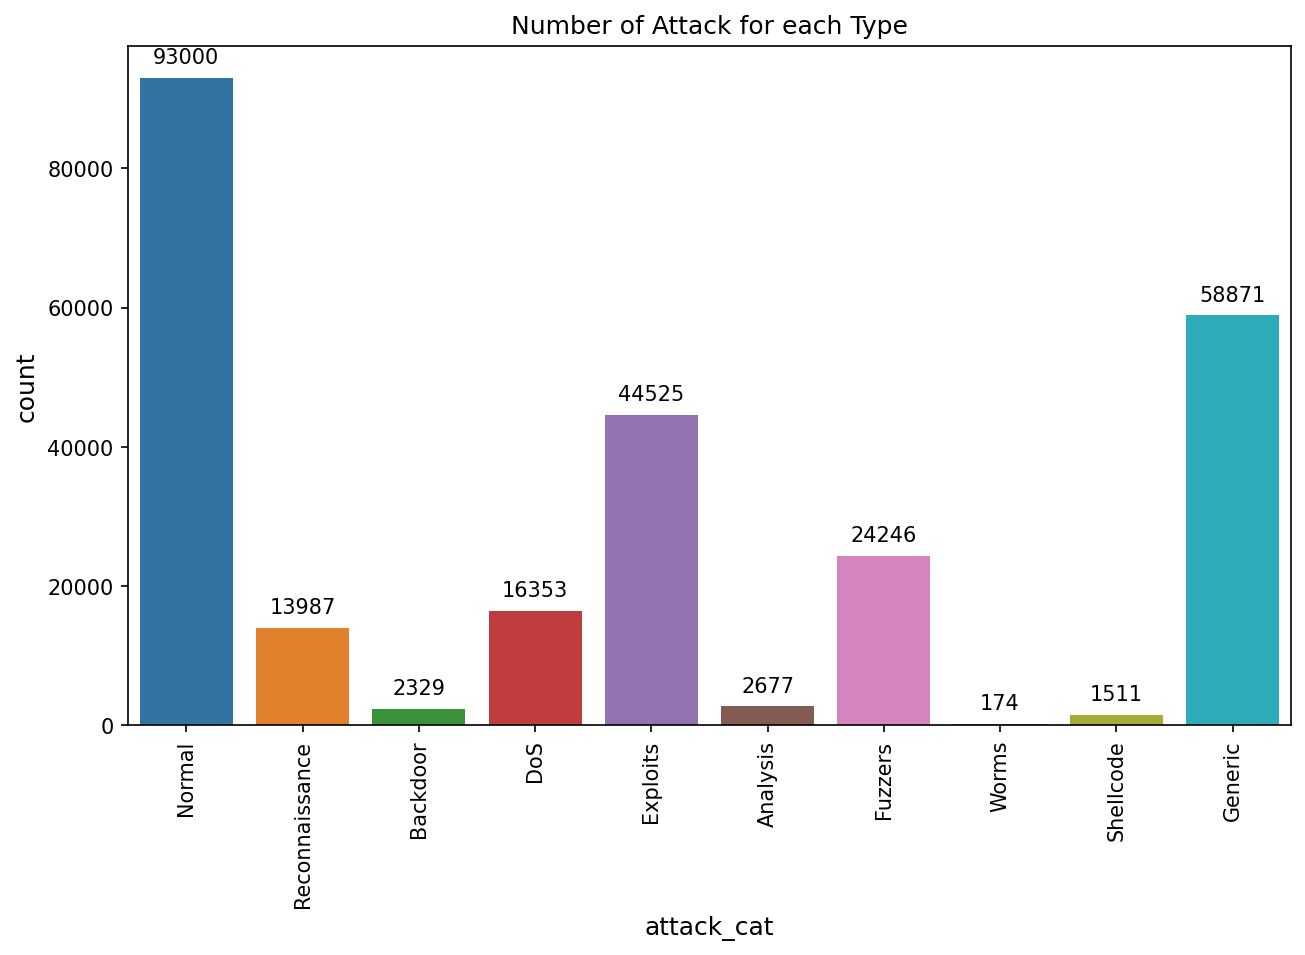

In [33]:
import seaborn as sn
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1, figsize=(10, 6))

# Rotasi countplot
sn.countplot(x='attack_cat', data=df, ax=ax)
ax.set_title('Number of Attack for each Type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Rotasi label pada sumbu x

# Menambahkan label pada grafik batang
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


In [8]:
df.label.unique()

array([0, 1], dtype=int64)

In [9]:
df.label.value_counts()

1    164673
0     93000
Name: label, dtype: int64

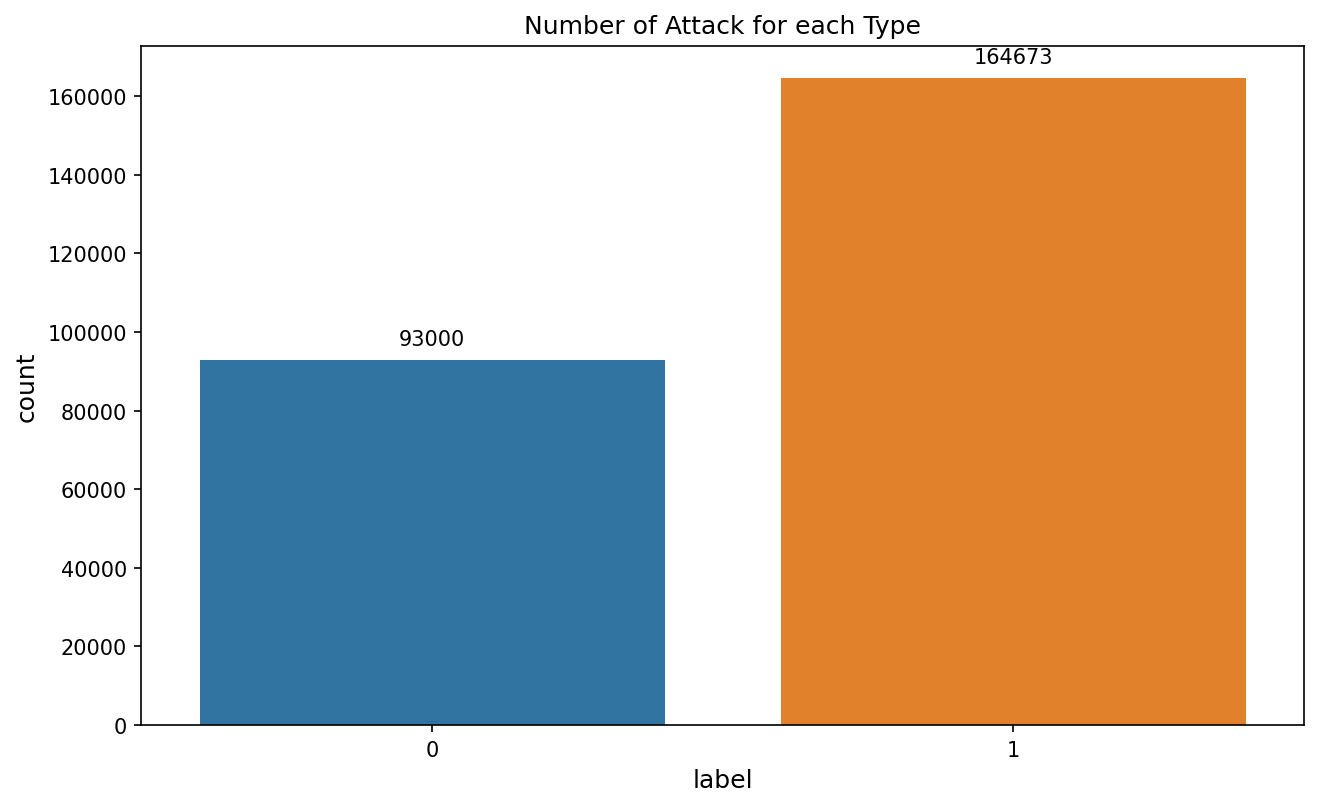

In [29]:
import seaborn as sn
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1, figsize=(10, 6))

# Rotasi countplot
sn.countplot(x='label', data=df, ax=ax)
ax.set_title('Number of Attack for each Type')
ax.set_xticklabels(ax.get_xticklabels())  # Rotasi label pada sumbu x

# Menambahkan label pada grafik batang
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()


In [34]:
df.drop(['id', 'proto', 'service', 'state'], axis=1, inplace=True)
# Split the dataset into input features and target variable
X = df.drop(['attack_cat'], axis=1)
y = df['attack_cat']

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [36]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
start_time = time.time()

# instantiate the label encoder
le = LabelEncoder()

# fit and transform the target data using the label encoder
y_train_encoded = le.fit_transform(y_train)

# instantiate the classifier 
xgb_clf = XGBClassifier(tree_method='hist', random_state=42)

# fit the classifier to the training data
eval_set = [(X_train, y_train_encoded), (X_test, le.transform(y_test))]
xgb_clf.fit(X_train, y_train_encoded, early_stopping_rounds=100, eval_metric=["merror", "mlogloss","auc"], eval_set=eval_set, verbose=True)

# make predictions on test data
predictions_XGB = le.inverse_transform(xgb_clf.predict(X_test))
XGB_time = (time.time() - start_time)

print("n_estimator 100: %f" % (XGB_time))
print()
print("elapsed time in seconds: ", XGB_time)

print()
gc.collect()


C:\Users\Admin\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-merror:0.13680	validation_0-mlogloss:1.25644	validation_0-auc:0.98214	validation_1-merror:0.13685	validation_1-mlogloss:1.25716	validation_1-auc:0.98197
[1]	validation_0-merror:0.13229	validation_0-mlogloss:0.97058	validation_0-auc:0.98350	validation_1-merror:0.13161	validation_1-mlogloss:0.97109	validation_1-auc:0.98333
[2]	validation_0-merror:0.13162	validation_0-mlogloss:0.79120	validation_0-auc:0.98437	validation_1-merror:0.13123	validation_1-mlogloss:0.79204	validation_1-auc:0.98410
[3]	validation_0-merror:0.13046	validation_0-mlogloss:0.66849	validation_0-auc:0.98479	validation_1-merror:0.12996	validation_1-mlogloss:0.66938	validation_1-auc:0.98455
[4]	validation_0-merror:0.12938	validation_0-mlogloss:0.58025	validation_0-auc:0.98520	validation_1-merror:0.12923	validation_1-mlogloss:0.58152	validation_1-auc:0.98495
[5]	validation_0-merror:0.12888	validation_0-mlogloss:0.51682	validation_0-auc:0.98541	validation_1-merror:0.12885	validation_1-mlogloss:0.51848	valid

[48]	validation_0-merror:0.11117	validation_0-mlogloss:0.28038	validation_0-auc:0.98895	validation_1-merror:0.11794	validation_1-mlogloss:0.29881	validation_1-auc:0.98738
[49]	validation_0-merror:0.11103	validation_0-mlogloss:0.27990	validation_0-auc:0.98899	validation_1-merror:0.11791	validation_1-mlogloss:0.29862	validation_1-auc:0.98737
[50]	validation_0-merror:0.11073	validation_0-mlogloss:0.27896	validation_0-auc:0.98907	validation_1-merror:0.11786	validation_1-mlogloss:0.29832	validation_1-auc:0.98739
[51]	validation_0-merror:0.11055	validation_0-mlogloss:0.27825	validation_0-auc:0.98911	validation_1-merror:0.11790	validation_1-mlogloss:0.29815	validation_1-auc:0.98739
[52]	validation_0-merror:0.11032	validation_0-mlogloss:0.27757	validation_0-auc:0.98915	validation_1-merror:0.11790	validation_1-mlogloss:0.29794	validation_1-auc:0.98740
[53]	validation_0-merror:0.10996	validation_0-mlogloss:0.27669	validation_0-auc:0.98920	validation_1-merror:0.11795	validation_1-mlogloss:0.29779

[96]	validation_0-merror:0.10140	validation_0-mlogloss:0.25565	validation_0-auc:0.99066	validation_1-merror:0.11729	validation_1-mlogloss:0.29402	validation_1-auc:0.98752
[97]	validation_0-merror:0.10133	validation_0-mlogloss:0.25528	validation_0-auc:0.99069	validation_1-merror:0.11740	validation_1-mlogloss:0.29405	validation_1-auc:0.98752
[98]	validation_0-merror:0.10096	validation_0-mlogloss:0.25486	validation_0-auc:0.99072	validation_1-merror:0.11742	validation_1-mlogloss:0.29408	validation_1-auc:0.98751
[99]	validation_0-merror:0.10090	validation_0-mlogloss:0.25452	validation_0-auc:0.99074	validation_1-merror:0.11740	validation_1-mlogloss:0.29401	validation_1-auc:0.98751
n_estimator 100: 28.246799

elapsed time in seconds:  28.246798992156982



NameError: name 'gc' is not defined

In [37]:
# print Over and Under fitting the scores on training and test set

print('Training set score: {:.4f}'.format(xgb_clf.score(X_train, y_train_encoded)))

print('Test set score: {:.4f}'.format(xgb_clf.score(X_test, le.transform(y_test))))

Training set score: 0.8981
Test set score: 0.8827


In [38]:
import warnings
warnings.filterwarnings("ignore")

import logging

logging.basicConfig(filename='log.txt',level=logging.DEBUG, format='%(asctime)s %(message)s')
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, precision_score, f1_score

print(classification_report(y_test, predictions_XGB))
# evaluate predictions
accuracy_XGB = accuracy_score(y_test, predictions_XGB)
print("Accuracy: %.10f%%" % (accuracy_XGB  * 100.0))
print('Test set score: {:.10f}'.format(accuracy_XGB))

                precision    recall  f1-score   support

      Analysis       0.84      0.18      0.30       846
      Backdoor       0.89      0.09      0.16       695
           DoS       0.44      0.15      0.23      4850
      Exploits       0.64      0.90      0.75     13457
       Fuzzers       0.91      0.88      0.89      7212
       Generic       1.00      0.98      0.99     17750
        Normal       1.00      1.00      1.00     27892
Reconnaissance       0.92      0.76      0.83      4107
     Shellcode       0.64      0.65      0.64       453
         Worms       0.48      0.55      0.51        40

      accuracy                           0.88     77302
     macro avg       0.77      0.62      0.63     77302
  weighted avg       0.88      0.88      0.87     77302

Accuracy: 88.2680913819%
Test set score: 0.8826809138


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

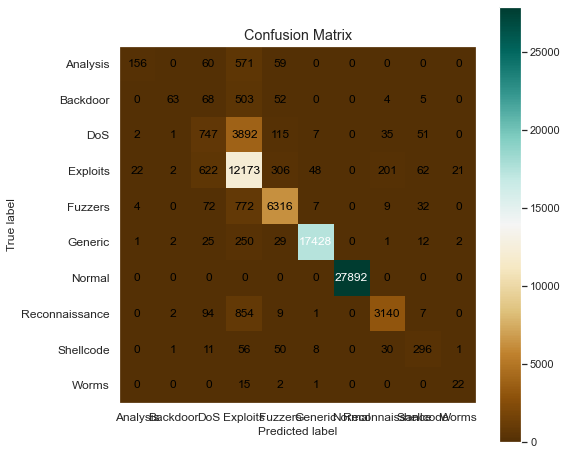

In [39]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

sns.set(rc={'figure.figsize':(8,8)})
skplt.metrics.plot_confusion_matrix(y_test, predictions_XGB, cmap="BrBG")

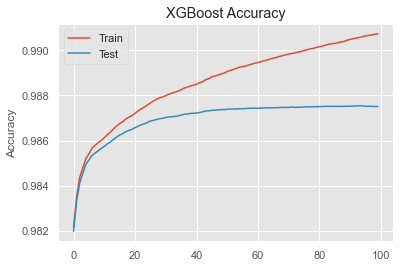

In [40]:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from tqdm import tqdm_notebook
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# retrieve performance metrics
results = xgb_clf.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('Accuracy')
plt.title('XGBoost Accuracy')
plt.show()

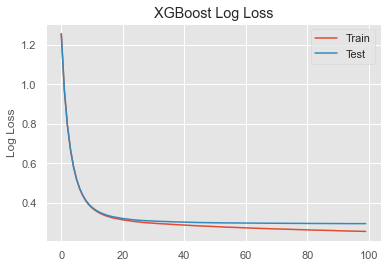

In [41]:
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

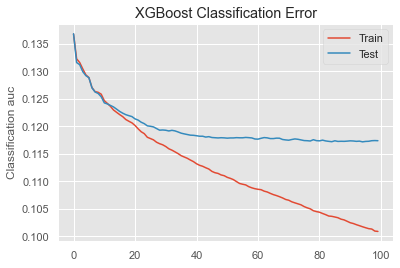

In [42]:
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification auc')
plt.title('XGBoost Classification Error')
plt.show()

In [43]:
# Split the dataset into input features and target variable
X_CWXGB = df.drop(['attack_cat'], axis=1)
y_CWXGB = df['attack_cat']

X_train_CWXGB, X_test_CWXGB, y_train_CWXGB, y_test_CWXGB = train_test_split(X_CWXGB, y_CWXGB, test_size = 0.3, random_state = 0)
# instantiate the label encoder
le = LabelEncoder()

# fit and transform the target data using the label encoder
y_train_CWXGB_encoded = le.fit_transform(y_train_CWXGB)

In [44]:
def imbalance_ratio(y_CWXGB, class_label):
    n_samples = len(y_CWXGB)
    class_count = np.sum(y_CWXGB == class_label)
    
    ir = (n_samples - class_count) / n_samples
    return ir

def calculate_fir(y_CWXGB):
    unique_classes = np.unique(y_CWXGB)
    fir_values = []

    for class_label in unique_classes:
        ir = imbalance_ratio(y_CWXGB, class_label)
        fir_values.append(ir)

    return max(fir_values)
# Contoh penggunaan
imbalance = calculate_fir(y_CWXGB)
print(f"Label y: {y_CWXGB.values}")
print(f"Max FIR for all classes in y: {imbalance:.10f}")

Label y: ['Normal' 'Normal' 'Normal' ... 'Generic' 'Generic' 'Generic']
Max FIR for all classes in y: 0.9993247255


In [48]:
def xgboost_objective(max_delta_step,max_depth, learning_rate, subsample, colsample_bytree, gamma, min_child_weight):
    params = {
        'objective': 'multi:softmax',
        'num_class': 10,
        'tree_method': 'hist',
        'max_delta_step' : max_delta_step,
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'gamma': gamma,
        'min_child_weight': min_child_weight
    }
    # transform the target data using the label encoder
    y_train_CWXGB_encoded = le.transform(y_train_CWXGB)
    dtrain = xgb.DMatrix(X_train_CWXGB, label=y_train_CWXGB_encoded)
    dval = xgb.DMatrix(X_test_CWXGB, label=le.transform(y_test_CWXGB))
    model = xgb.train(params, dtrain, evals=[(dval, 'validation')], early_stopping_rounds=10, verbose_eval=False)
    val_score = model.best_score
    return -val_score


In [49]:
# Define the search space for the hyperparameters
pbounds = {
#    'n_estimators': (50, 200),
    'max_delta_step' :(0, 10),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.5),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1),
    'gamma': (0, 1),
    'min_child_weight': (1, 10)
}

In [50]:
# Perform Bayesian optimization
optimizer = BayesianOptimization(f=xgboost_objective, pbounds=pbounds, random_state=42)
optimizer.maximize(init_points=10, n_iter=40)

|   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | -0.4051   | 0.6873    | 0.9507    | 0.3687    | 5.987     | 4.092     | 2.404     | 0.529     |
| 2         | -1.291    | 0.9331    | 0.6011    | 0.357     | 0.2058    | 9.789     | 8.492     | 0.6062    |
| 3         | -0.6487   | 0.5909    | 0.1834    | 0.1591    | 5.248     | 6.024     | 3.621     | 0.8059    |
| 4         | -0.5492   | 0.5697    | 0.2921    | 0.1895    | 4.561     | 8.496     | 2.797     | 0.7571    |
| 5         | -0.4994   | 0.7962    | 0.04645   | 0.3077    | 1.705     | 3.455     | 9.54      | 0.9828    |
| 6         | -1.183    | 0.9042    | 0.3046    | 0.05786   | 6.842     | 6.081     | 2.098     | 0.7476    |
| 7         | -0.7483   | 0.5172    | 0.9093    | 0.1368    | 6.625     | 5.182     | 5.681     | 0.7734    |
| 8       

| 45        | -0.3586   | 1.0       | 0.0       | 0.5       | 8.001     | 4.958     | 9.676     | 1.0       |
| 46        | -0.3839   | 1.0       | 1.0       | 0.5       | 7.41      | 3.282     | 10.0      | 0.5       |
| 47        | -0.3144   | 1.0       | 1.0       | 0.5       | 5.135     | 8.452     | 5.313     | 1.0       |
| 48        | -0.3218   | 1.0       | 0.0       | 0.5       | 8.829     | 7.57      | 10.0      | 1.0       |
| 49        | -0.3437   | 1.0       | 1.0       | 0.5       | 9.815     | 5.983     | 10.0      | 0.5       |
| 50        | -0.4915   | 0.6572    | 0.5511    | 0.2974    | 9.872     | 3.57      | 9.822     | 0.707     |


In [51]:
# Print the best score and parameters
print(optimizer.max)

{'target': -0.30659948912189094, 'params': {'colsample_bytree': 1.0, 'gamma': 1.0, 'learning_rate': 0.5, 'max_delta_step': 7.904275018242657, 'max_depth': 10.0, 'min_child_weight': 3.8977695244129564, 'subsample': 1.0}}


In [54]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
start_time = time.time()

# instantiate the label encoder
le = LabelEncoder()

# fit and transform the target data using the label encoder
y_train_CWXGB_encoded = le.fit_transform(y_train_CWXGB)


# Train the XGBoost model using the best hyperparameters
best_xgb_params = {
    'objective': 'multi:softprob',
    'num_class': 5,
    'scale_pos_weight' : imbalance,
    'tree_method' : 'hist',
#    'n_estimators': int(optimizer.max['params']['n_estimators']),
    'max_delta_step': int(optimizer.max['params']['max_delta_step']),
    'max_depth': int(optimizer.max['params']['max_depth']),
    'learning_rate': optimizer.max['params']['learning_rate'],
    'subsample': optimizer.max['params']['subsample'],
    'colsample_bytree': optimizer.max['params']['colsample_bytree'],
    'gamma': optimizer.max['params']['gamma'],
    'min_child_weight': optimizer.max['params']['min_child_weight']
}
#dtrain = xgb.DMatrix(X_train, label=y_train)
#dtest = xgb.DMatrix(X_test, label=y_test)
#best_model = xgb.train(best_xgb_params, dtrain, evals=[(dtest, 'validation', 'auc')], early_stopping_rounds=100, verbose_eval=True)
xgb_clf_CWXGB = xgb.XGBClassifier(**best_xgb_params, eval_metric=["mlogloss", "merror", "auc"], early_stopping_rounds=100)

eval_set_CWXGB = [(X_train_CWXGB, y_train_CWXGB_encoded), (X_test_CWXGB, le.transform(y_test_CWXGB))]
xgb_clf_CWXGB.fit(X_train_CWXGB, y_train_CWXGB_encoded, eval_set=eval_set_CWXGB, verbose=True)
XGB_time_CWXGB = (time.time() - start_time)
print("n_estimator 100: %f" % (XGB_time_CWXGB))
print()
print("elapsed time in seconds: ", XGB_time_CWXGB)

print()
gc.collect()

# make predictions on test data
predictions_XGB_CWXGB = le.inverse_transform(xgb_clf_CWXGB.predict(X_test_CWXGB))

print()
gc.collect()


[19:03:06] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[0]	validation_0-mlogloss:0.75810	validation_0-merror:0.11962	validation_0-auc:0.98617	validation_1-mlogloss:0.76328	validation_1-merror:0.12344	validation_1-auc:0.98515
[1]	validation_0-mlogloss:0.56541	validation_0-merror:0.11669	validation_0-auc:0.98732	validation_1-mlogloss:0.57360	validation_1-merror:0.12121	validation_1-auc:0.98615
[2]	validation_0-mlogloss:0.45775	validation_0-merror:0.11518	validation_0-auc:0.98785	validation_1-mlogloss:0.46818	validation_1-merror:0.12029	validation_1-auc:0.98657
[3]	validation_0-mlogloss:0.39366	validation_0-merror:0.11385	validation_0-auc:0.98820	validation_1-mlogloss:0.40594	validation_1-merror:0.11969	validation_1-auc:0.98687
[4]	validation_0-mlogloss:0.35380	validation_0-merror:0.11270	validation_0-auc:0.98848	validation_1-mlogloss:0.367

[47]	validation_0-mlogloss:0.26562	validation_0-merror:0.10582	validation_0-auc:0.99000	validation_1-mlogloss:0.29416	validation_1-merror:0.11720	validation_1-auc:0.98765
[48]	validation_0-mlogloss:0.26562	validation_0-merror:0.10582	validation_0-auc:0.99000	validation_1-mlogloss:0.29416	validation_1-merror:0.11720	validation_1-auc:0.98765
[49]	validation_0-mlogloss:0.26562	validation_0-merror:0.10582	validation_0-auc:0.99000	validation_1-mlogloss:0.29416	validation_1-merror:0.11720	validation_1-auc:0.98765
[50]	validation_0-mlogloss:0.26562	validation_0-merror:0.10582	validation_0-auc:0.99000	validation_1-mlogloss:0.29416	validation_1-merror:0.11720	validation_1-auc:0.98765
[51]	validation_0-mlogloss:0.26562	validation_0-merror:0.10582	validation_0-auc:0.99000	validation_1-mlogloss:0.29416	validation_1-merror:0.11720	validation_1-auc:0.98765
[52]	validation_0-mlogloss:0.26562	validation_0-merror:0.10582	validation_0-auc:0.99000	validation_1-mlogloss:0.29416	validation_1-merror:0.11720

[95]	validation_0-mlogloss:0.26562	validation_0-merror:0.10582	validation_0-auc:0.99000	validation_1-mlogloss:0.29416	validation_1-merror:0.11720	validation_1-auc:0.98765
[96]	validation_0-mlogloss:0.26562	validation_0-merror:0.10582	validation_0-auc:0.99000	validation_1-mlogloss:0.29416	validation_1-merror:0.11720	validation_1-auc:0.98765
[97]	validation_0-mlogloss:0.26562	validation_0-merror:0.10582	validation_0-auc:0.99000	validation_1-mlogloss:0.29416	validation_1-merror:0.11720	validation_1-auc:0.98765
[98]	validation_0-mlogloss:0.26562	validation_0-merror:0.10582	validation_0-auc:0.99000	validation_1-mlogloss:0.29416	validation_1-merror:0.11720	validation_1-auc:0.98765
[99]	validation_0-mlogloss:0.26562	validation_0-merror:0.10582	validation_0-auc:0.99000	validation_1-mlogloss:0.29416	validation_1-merror:0.11720	validation_1-auc:0.98765
n_estimator 100: 23.641251

elapsed time in seconds:  23.64125108718872




0

In [55]:
xgb_clf_CWXGB.get_xgb_params()

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 1.0,
 'eval_metric': ['mlogloss', 'merror', 'auc'],
 'gamma': 1.0,
 'gpu_id': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': 0.5,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': 7,
 'max_depth': 10,
 'max_leaves': None,
 'min_child_weight': 3.8977695244129564,
 'monotone_constraints': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 0.9993247255242109,
 'subsample': 1.0,
 'tree_method': 'hist',
 'validate_parameters': None,
 'verbosity': None,
 'num_class': 5}

In [56]:
import warnings
warnings.filterwarnings("ignore")

import logging

logging.basicConfig(filename='log.txt',level=logging.DEBUG, format='%(asctime)s %(message)s')
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, precision_score, f1_score

print(classification_report(y_test_CWXGB, predictions_XGB_CWXGB))
# evaluate predictions
accuracy_XGB_CWXGB = accuracy_score(y_test_CWXGB, predictions_XGB_CWXGB)
print("Accuracy: %.10f%%" % (accuracy_XGB_CWXGB  * 100.0))
print('Accuracy score: {:.10f}'.format(accuracy_XGB_CWXGB))

                precision    recall  f1-score   support

      Analysis       0.83      0.19      0.31       846
      Backdoor       0.88      0.09      0.16       695
           DoS       0.42      0.22      0.29      4850
      Exploits       0.65      0.88      0.75     13457
       Fuzzers       0.93      0.87      0.90      7212
       Generic       1.00      0.98      0.99     17750
        Normal       1.00      1.00      1.00     27892
Reconnaissance       0.91      0.77      0.83      4107
     Shellcode       0.63      0.59      0.61       453
         Worms       0.47      0.40      0.43        40

      accuracy                           0.88     77302
     macro avg       0.77      0.60      0.63     77302
  weighted avg       0.88      0.88      0.87     77302

Accuracy: 88.2810276578%
Accuracy score: 0.8828102766


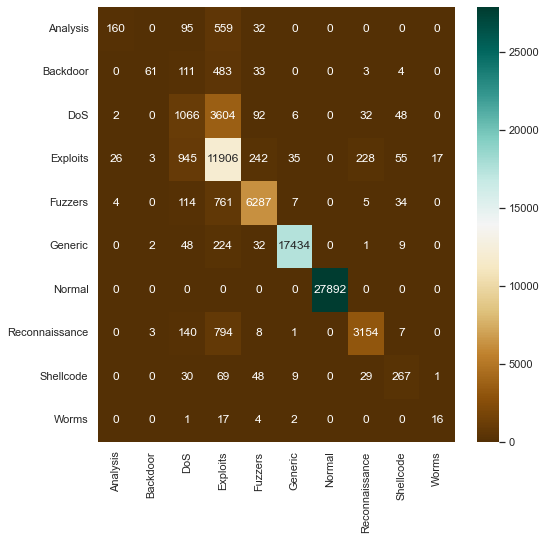

In [63]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

sns.set(rc={'figure.figsize':(8,8)})

# Plot confusion matrix
cm = confusion_matrix(y_test_CWXGB, predictions_XGB_CWXGB, labels=np.unique(y_test_CWXGB))
sns.heatmap(cm, annot=True, fmt="d", cmap="BrBG", xticklabels=np.unique(y_test_CWXGB), yticklabels=np.unique(y_test_CWXGB))

# Rotasi label pada sumbu x
plt.xticks(rotation=90)

plt.show()


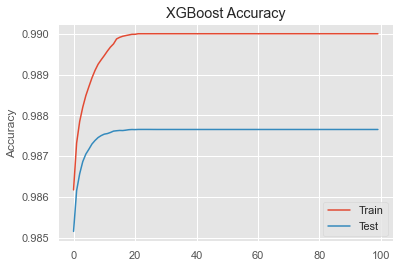

In [64]:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from tqdm import tqdm_notebook
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# retrieve performance metrics
results_CWXGB = xgb_clf_CWXGB.evals_result()
epochs = len(results_CWXGB['validation_0']['merror'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results_CWXGB['validation_0']['auc'], label='Train')
ax.plot(x_axis, results_CWXGB['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('Accuracy')
plt.title('XGBoost Accuracy')
plt.show()

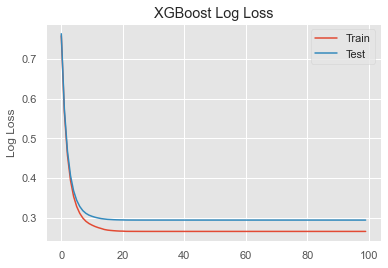

In [65]:
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results_CWXGB['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results_CWXGB['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

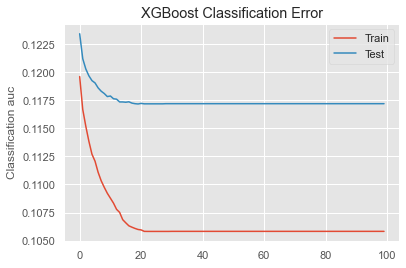

In [66]:
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results_CWXGB['validation_0']['merror'], label='Train')
ax.plot(x_axis, results_CWXGB['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Classification auc')
plt.title('XGBoost Classification Error')
plt.show()